# 감정 인식 모델 학습 연습: Kaggle FER 2018
- 01.learning.ipynb

In [1]:
!python -V

Python 3.12.4


In [2]:
import sys

print(sys.version)

3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]


In [60]:
# !{sys.executable} -m pip install -q tqdm # 설치 완료됨

In [3]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.utils import make_grid
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [4]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


In [5]:
import tensorflow as tf

# GPU 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 메모리 증가 허용 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [6]:
DATASET_HOME = "/Users/mks/Documents/GitHub/AI/archive"     # 상대경로로 설정하면 경로 오류남 ;-;
print(f"{DATASET_HOME = }")

DATASET_PATH = os.path.join(DATASET_HOME, "fer20131.csv")
print(f"{DATASET_PATH = }")

DATASET_HOME = '/Users/mks/Documents/GitHub/AI/archive'
DATASET_PATH = '/Users/mks/Documents/GitHub/AI/archive/fer20131.csv'


In [7]:
dataset = pd.read_csv(DATASET_PATH)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
dataset.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

- `Traning`, `PublicTest`를 합쳐서 학습 8 : validation 2 비율로 사용.
- `PrivateTest`는 최종 테스트 데이터로 사용

In [10]:
pixels = []

for pix in tqdm(dataset.pixels, total=len(dataset.pixels)):
    values = [int(i) for i in pix.split()]
    pixels.append(values)

print(len(pixels))

100%|███████████████████████████████████| 35887/35887 [00:04<00:00, 7579.85it/s]

35887


In [11]:
pixels = np.array(pixels)

# 0~255로 돼있는 픽셀 값을 0~1 범위로 변경
pixels = pixels / 255.0

pixels[0]

array([0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
       0.32156863])

In [12]:
dataset.drop(columns=["pixels"], axis=1, inplace=True)
dataset

,emotion,Usage
0,0,Training
1,0,Training
2,2,Training
3,4,Training
4,6,Training
...,...,...
35882,6,PrivateTest
35883,3,PrivateTest
35884,0,PrivateTest
35885,3,PrivateTest


In [13]:
pix_cols = []

# add each pixel value as a column
for i in tqdm(range(pixels.shape[1]), total=pixels.shape[1]):
    name = f"pixel_{i}"
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

100%|█████████████████████████████████████| 2304/2304 [00:00<00:00, 3740.11it/s]


In [14]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [15]:
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

In [16]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row["emotion"])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id


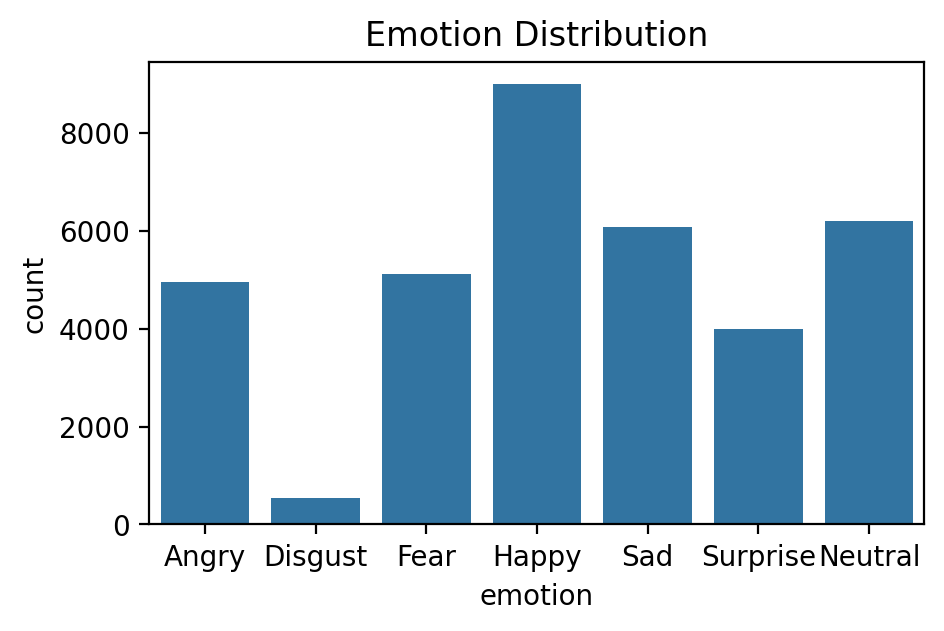

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

sns.countplot(x=dataset.emotion, ax=ax)
ax.set_title("Emotion Distribution")
ax.set_xticks(ticks=range(0, 7), labels=emotions.values())

plt.show()
plt.close(fig)

- `Disgust` 양이 너무 적음 (데이터불균형)

## 이미지에 다양한 전처리 및 변환 작업을 수행

In [18]:
def image_transformations() -> (object, object):
    print("image_transformations")

    train_trans = [
        T.RandomCrop(48, padding=4, padding_mode="reflect"),
        T.RandomRotation(15),
        T.RandomAffine(degrees=0, translate=(0.01, 0.12), shear=(0.01, 0.03)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(),
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

## Dataset and DataLoader

In [19]:
def get_train_dataset(
    dataframe: object, transformation: bool = True
) -> (object, object):
    """
    Returns an object on FERDataset class
    """
    dataframe = dataframe.loc[dataframe.Usage.isin(["Training", "PublicTest"])]
    dataframe = dataframe.drop("Usage", axis=1)

    # split dataset into training and validation set
    # seed 고정을 통해 난수를 일관되게 생성. 코드를 실행할 때마다 동일한 난수 순서를 얻을 수 있음
    # => 모델 학습 및 실험의 일관성 보장!
    np.random.seed(42)
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)

    return train_ds, val_ds

In [28]:
import torch.multiprocessing as mp
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
def get_train_dataloader(
    dataframe: object, transformation=True, batch_size: int = 64
) -> (object, object):
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)

    train_dl = DataLoader(
        train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True
    )
    valid_dl = DataLoader(valid_ds, batch_size * 2, num_workers=4, pin_memory=True)

    return train_dl, valid_dl


## Visualization

In [30]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

image_transformations


- multiprocessing error
- 해결함
- num_workers=4 로 설정
- `mp.set_start_method`를 `fork`변경 시 FERDataset 참조 에러 해결

In [31]:
mp.set_start_method('fork', force=True)

images.shape: torch.Size([64, 1, 48, 48])


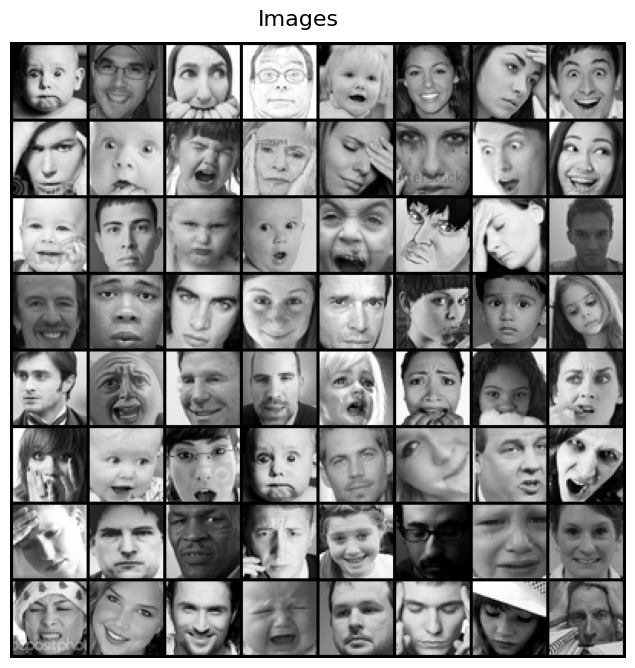

In [32]:
for images, _ in train_dl_un:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

images.shape: torch.Size([64, 1, 48, 48])


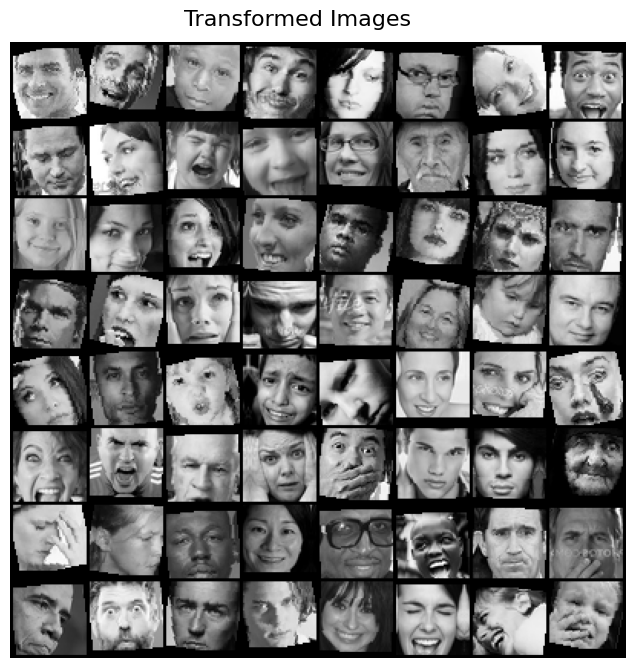

In [33]:
for images, _ in train_dl:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

In [35]:
def get_default_device():
    if torch.backends.mps.is_available():  # M1/M2 GPU 사용 확인
        print("Using MPS (Apple Silicon GPU)")
        return torch.device("mps")
    #elif torch.cuda.is_available():
    #    print("Using CUDA (NVIDIA GPU)")
    #    return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [36]:
device = get_default_device()
device

Using MPS (Apple Silicon GPU)


device(type='mps')

## Model Building

In [37]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"loss": loss, "acc": acc.detach()}

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}

    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = "val_loss"
            acc_ = "val_acc"
        else:
            loss_ = "loss"
            acc_ = "acc"

        batch_losses = [x[f"{loss_}"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x[f"{acc_}"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {
            f"{loss_}": epoch_loss.detach().item(),
            f"{acc_}": epoch_acc.detach().item(),
        }

    def epoch_end(self, epoch, result, num_epochs):
        print(
            f"Epoch: {epoch+1}/{num_epochs} -> lr: {result['lrs'][-1]:.5f} "
            f"loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, "
            f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n"
        )

## Metric

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))

    return nn.Sequential(*layers)

In [39]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 48 - 3 + 2 + 1 = 48
        self.conv1 = conv_block(in_channels, 48, pool=True)
        self.conv2 = conv_block(48, 96, pool=True)
        self.res1 = nn.Sequential(
            conv_block(96, 96, pool=False),
            conv_block(96, 96, pool=False),
        )

        self.conv3 = conv_block(96, 192, pool=True)
        self.conv4 = conv_block(192, 384, pool=True)

        self.res2 = nn.Sequential(conv_block(384, 384), conv_block(384, 384))

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes),
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def __repr__(self):
        return f"{self.network}"

    def __str__(self):
        summary(self.network, (1, 48, 48))

## Setup Training

In [40]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, val_loader: object) -> dict:
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object,
              epochs: int,
              max_lr: float,
              train_loader: object,
              val_loader: object,
              weight_decay: float = 0,
              grad_clip: float = None,
              opt_func: object = torch.optim.SGD):
    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=max_lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        train_history = []
        lrs = []

        # Training Phase
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']

            train_history.append(info)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

        train_result = model.get_metrics_epoch_end(
            train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs

        model.epoch_end(epoch, result, epochs)
        # 최고 score 모델 저장 코드
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [41]:
def get_test_dataloader(dataframe: object, batch_size: int = 128) -> object:
    test_df = dataframe.loc[dataset.Usage.isin(["PrivateTest"])]

    test_df = test_df.drop("Usage", axis=1)

    _, valid_tfms = image_transformations()

    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=8, pin_memory=True)

    # move loader to GPU
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

In [42]:
def load_best(model_name: str) -> object:
    best_model = models[model_name]

    path = "./"
    file_path = ""

    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path, i)) and i.startswith(f"{model_name}"):
            file_path = os.path.join(path, i)

    print(f"Loaded model: {file_path[2:]} weights")
    best_model.load_state_dict(torch.load(file_path))

    best_model = to_device(best_model, device)
    return best_model


@torch.no_grad()
def generate_prediction(model_name: str) -> None:
    test_dl = get_test_dataloader(dataset)

    model = load_best(model_name)

    torch.cuda.empty_cache()

    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

    print(
        f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, "
        f"Accuracy: {round(metrics['val_acc'], 3)}"
    )

In [43]:
def end_to_end(model_name: str, parameters: dict = None) -> dict:
    torch.cuda.empty_cache()

    train_dl, valid_dl = get_train_dataloader(
        dataset, batch_size=parameters["batch_size"]
    )

    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = models[model_name]

    model = to_device(model, device)

    # train model
    history = fit_model(
        model_name,
        model,
        parameters["epochs"],
        parameters["max_lr"],
        train_dl,
        valid_dl,
        parameters["weight_decay"],
        parameters["grad_clip"],
        parameters["opt_func"],
    )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Genearating predictions on the Test set")
    generate_prediction(model_name)
    return history

In [44]:
def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)),
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')


def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)),
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')


def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [45]:
models = {
    "ResNet9": ResNet9(in_channels=1, num_classes=7),
}

In [46]:
models["ResNet9"].__str__()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 48, 48]             480
       BatchNorm2d-2           [-1, 48, 48, 48]              96
              ReLU-3           [-1, 48, 48, 48]               0
         MaxPool2d-4           [-1, 48, 24, 24]               0
            Conv2d-5           [-1, 96, 24, 24]          41,568
       BatchNorm2d-6           [-1, 96, 24, 24]             192
              ReLU-7           [-1, 96, 24, 24]               0
         MaxPool2d-8           [-1, 96, 12, 12]               0
            Conv2d-9           [-1, 96, 12, 12]          83,040
      BatchNorm2d-10           [-1, 96, 12, 12]             192
             ReLU-11           [-1, 96, 12, 12]               0
           Conv2d-12           [-1, 96, 12, 12]          83,040
      BatchNorm2d-13           [-1, 96, 12, 12]             192
             ReLU-14           [-1, 96,

In [47]:
training_parameters = {
    "batch_size": 512,
    "epochs": 50,       # epochs 200 -> 50
    "max_lr": 0.01,
    "weight_decay": 0.0001,
    "grad_clip": 0.1,
    "opt_func": torch.optim.Adam,
}

In [48]:
model_name = "ResNet9"

history = end_to_end(model_name, training_parameters)

image_transformations


Epoch: 1/50: 100%|##############################| 64/64 [00:17<00:00,  3.64it/s]


Epoch: 1/50 -> lr: 0.00050 loss: 1.9818, acc: 0.2434, val_loss: 1.6713, val_acc: 0.3415

zsh:1: no matches found: ResNet9_*


Epoch: 2/50: 100%|##############################| 64/64 [00:17<00:00,  3.73it/s]


Epoch: 2/50 -> lr: 0.00081 loss: 1.7005, acc: 0.3409, val_loss: 1.4735, val_acc: 0.4376



Epoch: 3/50: 100%|##############################| 64/64 [00:16<00:00,  3.81it/s]


Epoch: 3/50 -> lr: 0.00131 loss: 1.4972, acc: 0.4274, val_loss: 1.3772, val_acc: 0.4618



Epoch: 4/50: 100%|##############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 4/50 -> lr: 0.00198 loss: 1.3723, acc: 0.4758, val_loss: 1.4235, val_acc: 0.4879



Epoch: 5/50: 100%|##############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 5/50 -> lr: 0.00279 loss: 1.3058, acc: 0.5037, val_loss: 1.3016, val_acc: 0.4929



Epoch: 6/50: 100%|##############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 6/50 -> lr: 0.00371 loss: 1.2785, acc: 0.5136, val_loss: 1.6063, val_acc: 0.4141



Epoch: 7/50: 100%|##############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 7/50 -> lr: 0.00469 loss: 1.2280, acc: 0.5339, val_loss: 1.1810, val_acc: 0.5478



Epoch: 8/50: 100%|##############################| 64/64 [00:16<00:00,  3.91it/s]


Epoch: 8/50 -> lr: 0.00569 loss: 1.2202, acc: 0.5372, val_loss: 1.3190, val_acc: 0.5118



Epoch: 9/50: 100%|##############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 9/50 -> lr: 0.00668 loss: 1.2085, acc: 0.5405, val_loss: 1.3402, val_acc: 0.4958



Epoch: 10/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 10/50 -> lr: 0.00760 loss: 1.1826, acc: 0.5536, val_loss: 1.3779, val_acc: 0.4971



Epoch: 11/50: 100%|#############################| 64/64 [00:16<00:00,  3.86it/s]


Epoch: 11/50 -> lr: 0.00841 loss: 1.1530, acc: 0.5638, val_loss: 1.5329, val_acc: 0.4544



Epoch: 12/50: 100%|#############################| 64/64 [00:16<00:00,  3.80it/s]


Epoch: 12/50 -> lr: 0.00908 loss: 1.1325, acc: 0.5728, val_loss: 1.6388, val_acc: 0.3973



Epoch: 13/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 13/50 -> lr: 0.00958 loss: 1.1198, acc: 0.5775, val_loss: 1.2263, val_acc: 0.5376



Epoch: 14/50: 100%|#############################| 64/64 [00:16<00:00,  3.98it/s]


Epoch: 14/50 -> lr: 0.00989 loss: 1.0918, acc: 0.5845, val_loss: 1.4785, val_acc: 0.4980



Epoch: 15/50: 100%|#############################| 64/64 [00:16<00:00,  3.98it/s]


Epoch: 15/50 -> lr: 0.01000 loss: 1.0819, acc: 0.5941, val_loss: 2.0454, val_acc: 0.3111



Epoch: 16/50: 100%|#############################| 64/64 [00:16<00:00,  3.98it/s]


Epoch: 16/50 -> lr: 0.00998 loss: 1.0794, acc: 0.5904, val_loss: 1.3827, val_acc: 0.4668



Epoch: 17/50: 100%|#############################| 64/64 [00:15<00:00,  4.01it/s]


Epoch: 17/50 -> lr: 0.00992 loss: 1.0725, acc: 0.5967, val_loss: 1.3045, val_acc: 0.4971



Epoch: 18/50: 100%|#############################| 64/64 [00:16<00:00,  3.88it/s]


Epoch: 18/50 -> lr: 0.00982 loss: 1.0493, acc: 0.6053, val_loss: 1.8279, val_acc: 0.3626



Epoch: 19/50: 100%|#############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 19/50 -> lr: 0.00968 loss: 1.0365, acc: 0.6113, val_loss: 1.1040, val_acc: 0.5929



Epoch: 20/50: 100%|#############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 20/50 -> lr: 0.00950 loss: 1.0220, acc: 0.6111, val_loss: 1.2036, val_acc: 0.5773



Epoch: 21/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 21/50 -> lr: 0.00929 loss: 1.0291, acc: 0.6140, val_loss: 1.1173, val_acc: 0.5812



Epoch: 22/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 22/50 -> lr: 0.00905 loss: 1.0100, acc: 0.6178, val_loss: 1.2328, val_acc: 0.5583



Epoch: 23/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 23/50 -> lr: 0.00877 loss: 1.0093, acc: 0.6226, val_loss: 1.1887, val_acc: 0.5497



Epoch: 24/50: 100%|#############################| 64/64 [00:16<00:00,  3.81it/s]


Epoch: 24/50 -> lr: 0.00846 loss: 0.9981, acc: 0.6248, val_loss: 1.1424, val_acc: 0.5767



Epoch: 25/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 25/50 -> lr: 0.00812 loss: 0.9868, acc: 0.6274, val_loss: 1.3335, val_acc: 0.5202



Epoch: 26/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 26/50 -> lr: 0.00775 loss: 0.9790, acc: 0.6327, val_loss: 0.9302, val_acc: 0.6528



Epoch: 27/50: 100%|#############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 27/50 -> lr: 0.00737 loss: 0.9654, acc: 0.6385, val_loss: 0.9386, val_acc: 0.6462



Epoch: 28/50: 100%|#############################| 64/64 [00:16<00:00,  3.94it/s]


Epoch: 28/50 -> lr: 0.00697 loss: 0.9591, acc: 0.6410, val_loss: 1.0069, val_acc: 0.6086



Epoch: 29/50: 100%|#############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 29/50 -> lr: 0.00655 loss: 0.9556, acc: 0.6409, val_loss: 1.1756, val_acc: 0.5600



Epoch: 30/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 30/50 -> lr: 0.00611 loss: 0.9421, acc: 0.6409, val_loss: 0.9774, val_acc: 0.6299



Epoch: 31/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 31/50 -> lr: 0.00567 loss: 0.9386, acc: 0.6499, val_loss: 0.8563, val_acc: 0.6800



Epoch: 32/50: 100%|#############################| 64/64 [00:16<00:00,  3.94it/s]


Epoch: 32/50 -> lr: 0.00522 loss: 0.9417, acc: 0.6446, val_loss: 0.8898, val_acc: 0.6634



Epoch: 33/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 33/50 -> lr: 0.00478 loss: 0.9091, acc: 0.6596, val_loss: 0.8562, val_acc: 0.6770



Epoch: 34/50: 100%|#############################| 64/64 [00:16<00:00,  3.98it/s]


Epoch: 34/50 -> lr: 0.00433 loss: 0.8978, acc: 0.6627, val_loss: 0.8694, val_acc: 0.6703



Epoch: 35/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 35/50 -> lr: 0.00389 loss: 0.8866, acc: 0.6678, val_loss: 0.8410, val_acc: 0.6805



Epoch: 36/50: 100%|#############################| 64/64 [00:16<00:00,  3.94it/s]


Epoch: 36/50 -> lr: 0.00345 loss: 0.8761, acc: 0.6696, val_loss: 0.8268, val_acc: 0.6894



Epoch: 37/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 37/50 -> lr: 0.00303 loss: 0.8634, acc: 0.6747, val_loss: 0.8232, val_acc: 0.6890



Epoch: 38/50: 100%|#############################| 64/64 [00:15<00:00,  4.01it/s]


Epoch: 38/50 -> lr: 0.00263 loss: 0.8461, acc: 0.6806, val_loss: 0.7835, val_acc: 0.7083



Epoch: 39/50: 100%|#############################| 64/64 [00:16<00:00,  3.85it/s]


Epoch: 39/50 -> lr: 0.00225 loss: 0.8323, acc: 0.6872, val_loss: 0.8025, val_acc: 0.6942



Epoch: 40/50: 100%|#############################| 64/64 [00:17<00:00,  3.62it/s]


Epoch: 40/50 -> lr: 0.00188 loss: 0.8084, acc: 0.6980, val_loss: 0.7046, val_acc: 0.7367



Epoch: 41/50: 100%|#############################| 64/64 [00:16<00:00,  3.83it/s]


Epoch: 41/50 -> lr: 0.00154 loss: 0.7886, acc: 0.7072, val_loss: 0.6983, val_acc: 0.7425



Epoch: 42/50: 100%|#############################| 64/64 [00:17<00:00,  3.76it/s]


Epoch: 42/50 -> lr: 0.00123 loss: 0.7732, acc: 0.7127, val_loss: 0.6660, val_acc: 0.7535



Epoch: 43/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 43/50 -> lr: 0.00095 loss: 0.7434, acc: 0.7212, val_loss: 0.6421, val_acc: 0.7570



Epoch: 44/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 44/50 -> lr: 0.00071 loss: 0.7169, acc: 0.7336, val_loss: 0.6082, val_acc: 0.7754



Epoch: 45/50: 100%|#############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 45/50 -> lr: 0.00050 loss: 0.7006, acc: 0.7383, val_loss: 0.5874, val_acc: 0.7850



Epoch: 46/50: 100%|#############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 46/50 -> lr: 0.00032 loss: 0.6771, acc: 0.7493, val_loss: 0.5736, val_acc: 0.7876



Epoch: 47/50: 100%|#############################| 64/64 [00:17<00:00,  3.72it/s]


Epoch: 47/50 -> lr: 0.00018 loss: 0.6622, acc: 0.7541, val_loss: 0.5517, val_acc: 0.7970



Epoch: 48/50: 100%|#############################| 64/64 [00:16<00:00,  3.95it/s]


Epoch: 48/50 -> lr: 0.00008 loss: 0.6431, acc: 0.7625, val_loss: 0.5444, val_acc: 0.7992



Epoch: 49/50: 100%|#############################| 64/64 [00:17<00:00,  3.68it/s]


Epoch: 49/50 -> lr: 0.00002 loss: 0.6459, acc: 0.7600, val_loss: 0.5415, val_acc: 0.7994



Epoch: 50/50: 100%|#############################| 64/64 [00:16<00:00,  3.93it/s]


Epoch: 50/50 -> lr: 0.00000 loss: 0.6367, acc: 0.7657, val_loss: 0.5409, val_acc: 0.8001

Genearating predictions on the Test set
image_transformations
Loaded model: ResNet9_epoch-50_score-0.8001.pth weights
Test Scores:
 Loss: 0.834, Accuracy: 0.707


### `ResNet9_epoch-50_score-0.8001.pth`로 model 디렉토리에 저장